In [13]:
import librosa
import librosa.display
import os
import pandas as pd
import numpy as np
from time import time 
import random as rd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import threading
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

path_to_db_voice = "C:\\Users\\antoi\Desktop\\Airbus\\projet_AIRBUS\\db\\voice\\"
path_to_db_plane = "C:\\Users\\antoi\Desktop\\Airbus\\projet_AIRBUS\\db\\plane\\"
path_to_db_both = "C:\\Users\\antoi\Desktop\\Airbus\\projet_AIRBUS\\db\\both\\"

l_voice_records = os.listdir(path_to_db_voice)
l_airplane_records = os.listdir(path_to_db_plane)
l_both_records = os.listdir(path_to_db_both)

In [14]:
def separe_train_test(db_folder_path,n_records,test_size):
    l_records = os.listdir(db_folder_path)
    sub_l_records = rd.sample(l_records,n_records)
    size = len(sub_l_records)
    sep = round(test_size*size)
    sample = rd.sample(sub_l_records,size)
    test = sample[:sep]
    train = sample[sep:]
    return train,test

In [15]:
def gen_X_train_test(db_folder_path,n_records,test_size):
    sp_rec_train = []
    sp_rec_test = []
    hops_train = []
    hops_test = []
    records_train,records_test = separe_train_test(db_folder_path,n_records,test_size)
    i = 0
    for record in records_train:
        print('Building train {}/{}'.format(i,len(records_train)),end='\r')
        signal,sample_rate = librosa.load(db_folder_path + record)
        spectrum = librosa.stft(y=signal,center=False) 
        spectrum = spectrum.astype(float)
        sp_rec_train.append(np.abs(np.transpose(spectrum)))
        hops_train.append(len(signal)//len(spectrum))
        i+=1

        # plt.hist(np.unique(spectrum),bins=200)
        # plt.yscale('log')
        # fig = librosa.display.specshow(spectrum, sr=sample_rate, x_axis='time', y_axis='log')
        # plt.colorbar(format='%+2.0f dB')
        # plt.title('Spectrogram')
        # plt.plot()
        # plt.show()
    i=0
    for record in records_test: 
        print('Building  test {}/{}'.format(i,len(records_test)),end='\r')
        signal,sample_rate = librosa.load(db_folder_path + record)
        spectrum = librosa.stft(y=signal,center=False) 
        spectrum = spectrum.astype(float)
        sp_rec_test.append(np.abs(np.transpose(spectrum)))
        hops_test.append(len(signal)//len(spectrum))
        i+=1

    X_train = np.concatenate(sp_rec_train)
    X_test = np.concatenate(sp_rec_test)

    return X_train,X_test,hops_train,hops_test

In [16]:
n_records = 178

X_voice_train,X_voice_test,hops_voice_train,hops_voice_test= gen_X_train_test(path_to_db_voice,n_records,0.3)
print('Voice done',end='\r')
X_plane_train,X_plane_test,hops_plane_train,hops_plane_test = gen_X_train_test(path_to_db_plane,n_records,0.3)
print('Plane done',end='\r')
X_both_train,X_both_test,hops_both_train,hops_both_test = gen_X_train_test(path_to_db_both,n_records,0.3)
print('Both done',end='\r')

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

threshold = 10


import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

y_voice_train = ['Voice' for elt in X_voice_train]
y_plane_train = ['Plane' for elt in X_plane_train]
y_both_train = ['Voice' for elt in X_both_train]

y_voice_test = ['Voice' for elt in X_voice_test]
y_plane_test = ['Plane' for elt in X_plane_test]
y_both_test = ['Voice' for elt in X_both_test]


Y = y_voice_train + y_plane_train + y_both_train + y_plane_test + y_both_test
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)


X_train = np.concatenate([X_voice_train,X_plane_train,X_both_train])
X_test = np.concatenate([X_plane_test,X_both_test])

y_train = dummy_y[:len(y_voice_train) + len(y_plane_train) + len(y_both_train)]
y_test = dummy_y[len(y_voice_train) + len(y_plane_train) + len(y_both_train)::]

In [66]:
encoded_Y[0]
dummy_y[0]

array([0., 1.], dtype=float32)

In [58]:
def model():
    model = Sequential()
    model.add(Dense(32,input_dim=1025, activation='relu'))
    model.add(Dense(16, input_dim=32, activation = 'sigmoid'))
    #model.add(Dropout(0.3))
    #model.add(Dense(16, activation = 'sigmoid'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [59]:
X_test.shape

(57263, 1025)

In [60]:
nn = model()
nn.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
3155/3155 [==============================] - 4s 1ms/step - loss: 0.3535 - accuracy: 0.8267
Epoch 2/20
3155/3155 [==============================] - 3s 1ms/step - loss: 0.2967 - accuracy: 0.8581
Epoch 3/20
3155/3155 [==============================] - 3s 1ms/step - loss: 0.2840 - accuracy: 0.8652
Epoch 4/20
3155/3155 [==============================] - 3s 1ms/step - loss: 0.2753 - accuracy: 0.8699
Epoch 5/20
3155/3155 [==============================] - 3s 1ms/step - loss: 0.2688 - accuracy: 0.8735
Epoch 6/20
3155/3155 [==============================] - 3s 1ms/step - loss: 0.2637 - accuracy: 0.8763
Epoch 7/20
3155/3155 [==============================] - 3s 1ms/step - loss: 0.2604 - accuracy: 0.8788
Epoch 8/20
3155/3155 [==============================] - 3s 1ms/step - loss: 0.2568 - accuracy: 0.8810
Epoch 9/20
3155/3155 [==============================] - 3s 1ms/step - loss: 0.2545 - accuracy: 0.8819
Epoch 10/20
3155/3155 [==============================] - 3s 1ms/step - loss: 0.252

1790/1790 [==============================] - 1s 584us/step
Accuracy is: 77.1248450133594


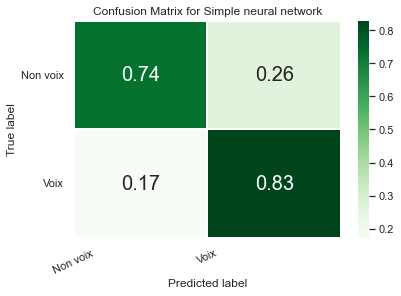

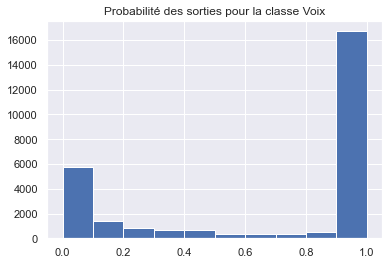

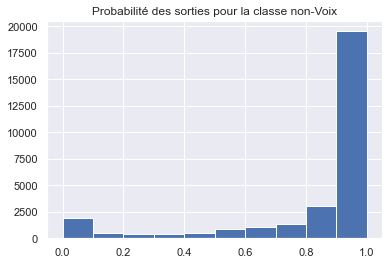

In [61]:
char_nn(nn)

In [8]:
y_pred = nn.predict(X_test)
y_pred_aux = []
for k in y_pred:
    if k[0]>k[1]:
        y_pred_aux.append([1,0])
    else:
        y_pred_aux.append([0,1])

1774/1774 [==============================] - 1s 535us/step


In [64]:
y_test_cm = []
for y in y_test:
    if y[0]==1:
        y_test_cm.append('Pas voix')
    else:
        y_test_cm.append('Voix')
        
y_pred_cm = []
for y in y_pred_aux:
    if y[0]==1:
        y_pred_cm.append('Pas voix')
    else:
        y_pred_cm.append('Voix')

y_test_cm[0]

'Pas voix'

In [9]:
from sklearn.metrics import confusion_matrix,accuracy_score

a = accuracy_score(y_pred_aux,y_test)
print('Accuracy is:', a*100)

Accuracy is: 76.2047396705136


In [27]:
def char_nn(modele):
    y_pred = modele.predict(X_test)
    y_pred_aux = []
    for k in y_pred:
        if k[0]>k[1]:
            y_pred_aux.append([1,0])
        else:
            y_pred_aux.append([0,1])
    y_test_cm = []
    for y in y_test:
        if y[0]==1:
            y_test_cm.append('Pas voix')
        else:
            y_test_cm.append('Voix')

    y_pred_cm = []
    for y in y_pred_aux:
        if y[0]==1:
            y_pred_cm.append('Pas voix')
        else:
            y_pred_cm.append('Voix')
            
    a = accuracy_score(y_pred_aux,y_test)
    print('Accuracy is:', a*100)
    
    matrix = confusion_matrix(y_pred_cm,y_test_cm)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(6,4))
    sns.set(font_scale=1)
    sns.heatmap(matrix, annot=True, annot_kws={'size':20},
                cmap=plt.cm.Greens, linewidths=0.2)

    # Add labels to the plot
    class_names = ['Non voix','Voix']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for Simple neural network')
    plt.show()
    
    histProbaV = []


    for i in range(len(y_pred)):
        probap,probav = y_pred[i][0],y_pred[i][1]
        if y_test[i][1]==1:
            histProbaV.append(probav)
    
    plt.hist(histProbaV)
    plt.title('Probabilité des sorties pour la classe Voix')
    plt.show()
    
    histProbaP = []
    for i in range(len(y_pred)):
        probap,probav = y_pred[i][0],y_pred[i][1]
        if y_test[i][0]==1:
            histProbaP.append(probap)
    
    plt.hist(histProbaP)
    plt.title('Probabilité des sorties pour la classe non-Voix')
    plt.show()

In [36]:
nn.save('nn.h5')

Epoch 1/20
3155/3155 [==============================] - 3s 938us/step - loss: 0.4185 - accuracy: 0.7876
Epoch 2/20
3155/3155 [==============================] - 3s 946us/step - loss: 0.3496 - accuracy: 0.8291
Epoch 3/20
3155/3155 [==============================] - 3s 933us/step - loss: 0.3291 - accuracy: 0.8409
Epoch 4/20
3155/3155 [==============================] - 3s 957us/step - loss: 0.3190 - accuracy: 0.8473
Epoch 5/20
3155/3155 [==============================] - 3s 932us/step - loss: 0.3132 - accuracy: 0.8512
Epoch 6/20
3155/3155 [==============================] - 3s 934us/step - loss: 0.3099 - accuracy: 0.8524
Epoch 7/20
3155/3155 [==============================] - 3s 934us/step - loss: 0.3076 - accuracy: 0.8541
Epoch 8/20
3155/3155 [==============================] - 3s 932us/step - loss: 0.3057 - accuracy: 0.8550
Epoch 9/20
3155/3155 [==============================] - 3s 921us/step - loss: 0.3041 - accuracy: 0.8563
Epoch 10/20
3155/3155 [==============================] - 3s 934u

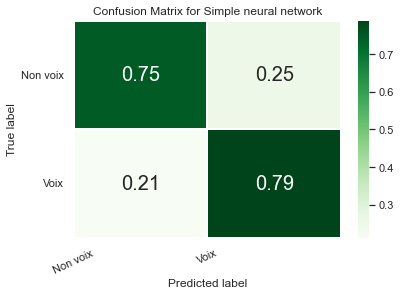

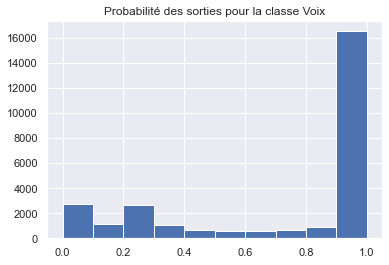

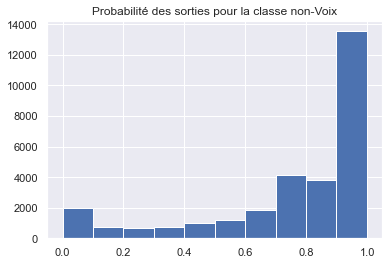

In [35]:
def model_simple():
    model = Sequential()
    model.add(Dense(8,input_dim=1025, activation='sigmoid'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
nn_simple_sig = model_simple()
nn_simple_sig.fit(X_train, y_train, epochs=20, batch_size=64)
char_nn(nn_simple_sig)

In [36]:
nn_simple_sig.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 8)                 8208      
                                                                 
 dense_25 (Dense)            (None, 2)                 18        
                                                                 
Total params: 8,226
Trainable params: 8,226
Non-trainable params: 0
_________________________________________________________________


In [37]:
preds = nn_simple_sig.predict(X_test)

1790/1790 [==============================] - 1s 541us/step


In [40]:
pred_filt = []
y_test_filt = []

for k in range(len(preds)):
    if preds[k][0]<0.1 or preds[k][0]>0.9:
        pred_filt.append(preds[k])
        y_test_filt.append(y_test[k])

In [41]:
print(len(pred_filt)/len(preds))

0.606901489618078


In [43]:
y_pred_aux = []
for k in pred_filt:
    if k[0]>k[1]:
        y_pred_aux.append([1,0])
    else:
        y_pred_aux.append([0,1])
        
a = accuracy_score(y_pred_aux,y_test_filt)
print('Accuracy is:', a*100)

Accuracy is: 86.39254165108048


In [50]:
def best_filt_aux(proba,preds):
    pred_filt = []
    y_test_filt = []

    for k in range(len(preds)):
        if preds[k][0]<(1-proba) or preds[k][0]>proba:
            pred_filt.append(preds[k])
            y_test_filt.append(y_test[k])
    y_pred_aux = []
    for k in pred_filt:
        if k[0]>k[1]:
            y_pred_aux.append([1,0])
        else:
            y_pred_aux.append([0,1])
    a = accuracy_score(y_pred_aux,y_test_filt)
    prop_filt = len(pred_filt)/len(preds)
    return(a,prop_filt)

1790/1790 [==============================] - 1s 520us/step


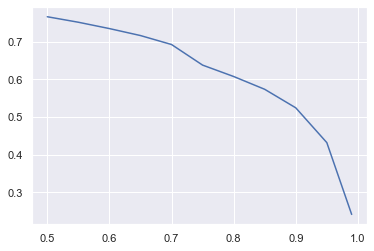

In [57]:
def best_filt():
    x = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99]
    preds = nn_simple_sig.predict(X_test)
    aux = [best_filt_aux(xi,preds) for xi in x]
    y = [a[0] for a in aux]
    p = [a[1] for a in aux]
    #plt.plot(x,y)
    #plt.title('Evolution de la précision en fonction du seuil appliqué')
    #plt.xlabel("Probabilité minimale pour une classe")
    #plt.ylabel('Précision')
    #plt.plot(x,p)
    #plt.show()
    #plt.plot(x,y, label="Précision")
    #plt.plot(x,p, label="Proportion gardée")
    #plt.legend()
    #plt.xlabel("Probabilité minimale pour une classe")
    #plt.title("Evolution de la précision et de la proportion d'enregistrement conservés en fonction du seuil appliqué")
    #plt.show()
    yxp = [y[k]*p[k] for k in range(len(y))]
    plt.plot(x,yxp)
best_filt()

In [44]:
y_test_cm = []
for y in y_test_filt:
    if y[0]==1:
        y_test_cm.append('Pas voix')
    else:
        y_test_cm.append('Voix')

y_pred_cm = []
for y in y_pred_aux:
    if y[0]==1:
        y_pred_cm.append('Pas voix')
    else:
        y_pred_cm.append('Voix')

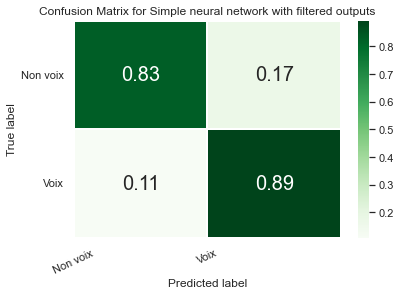

In [45]:
matrix = confusion_matrix(y_pred_cm,y_test_cm)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
plt.figure(figsize=(6,4))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
                cmap=plt.cm.Greens, linewidths=0.2)

    # Add labels to the plot
class_names = ['Non voix','Voix']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Simple neural network with filtered outputs')
plt.show()

In [ ]:
char_nn(nn)

In [ ]:
nn.summary()

In [18]:
bonnePredV = [] #liste des proba prédites pour la voix quand le modèle à raison
bonnePredP = []
mauvaisePredV = [] #liste des proba prédites pour la voix quand le modèle à tord
mauvaisePredP = []

histProbaV = []


for i in range(len(y_pred)):
    probap,probav = y_pred[i][0],y_pred[i][1]
    if y_test[i][1]==1:
        histProbaV.append(probav)

NameError: name 'y_pred' is not defined

In [33]:
import math as m
import matplotlib.pyplot as plt

def printCar(l):
    moyenne = sum(l)/len(l)
    print("Nombre d'éléments : " + str(len(l)))
    print("Moyenne des probas : " + str(moyenne))
    print("Max : " + str(max(l)) + ", Min : " + str(min(l)))
    ecart_type = m.sqrt(sum((k-moyenne)**2 for k in l) / len(l))
    print("Ecart type : " + str(ecart_type))
    plt.hist(l)

Nombre d'éléments : 23165
Moyenne des probas : 0.892643223041956
Max : 0.99864405, Min : 0.5000298
Ecart type : 0.1255779655457124
Nombre d'éléments : 20812
Moyenne des probas : 0.9724308094988872
Max : 1.0, Min : 0.5001022
Ecart type : 0.08638800159574725
Nombre d'éléments : 6688
Moyenne des probas : 0.13832400362636868
Max : 0.49996978, Min : 1.8889983e-09
Ecart type : 0.1584008007874397
Nombre d'éléments : 8825
Moyenne des probas : 0.13164855255505264
Max : 0.49982163, Min : 0.0013567158
Ecart type : 0.13789319421292784


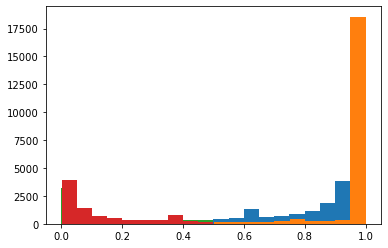

In [34]:
printCar(bonnePredV)
printCar(bonnePredP)
printCar(mauvaisePredV) #on prédit avion alors que c'est voix : histo des proba prédite pour voix par le modèle
printCar(mauvaisePredP) #on prédit voix alors que c'est avion : histo des proba prédite pour avion par le modèle

In [12]:
def signe(x):
    if x>0:
        return 1
    else:
        return -1

In [13]:
def has_voice_vote(X_batch,NNmodel):
    results = NNmodel.predict(X_batch)
    vote = 0
    for res in results:
        confiance = res[0]-res[1]
        if confiance>0.95:
            vote += 1
    proportion = vote/len(X_batch)
    if proportion > 0.5:
        return 1
    else:
        return 0